In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

## Thunder setup

In [2]:
import tensorflow as tf

# Check GPU availability
print("GPU Available:", tf.test.is_gpu_available())

# Check TPU availability
tpu_available = False
devices = tf.config.list_logical_devices()
for device in devices:
    if device.device_type == 'TPU':
        tpu_available = True
        break

print("TPU Available:", tpu_available)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available: True
TPU Available: False


In [3]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls  # Check if required cuda 9.0 amd64-deb file is downloaded
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls /var/cuda-repo-9-0-local | grep .pub
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update

--2024-11-28 13:22:20--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 152.195.19.142
Connecting to developer.nvidia.com (developer.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.nvidia.com/downloads/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb [following]
--2024-11-28 13:22:21--  https://developer.nvidia.com/downloads/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64.deb?JqWhAUsFwYojA3rlMAFFv-CiB4lU9mwbP9L0LpVfYf7RgR_sh0Z1_FXi38YKC2--bZTriVz_woBopbnmCmfIT

In [4]:
!DEBIAN_FRONTEND=noninteractive sudo apt-get install -y cuda-9.0

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libcuda-9.0-1' for regex 'cuda-9.0'
Note, selecting 'cuda-9-0' for regex 'cuda-9.0'
The following additional packages will be installed:
  cpp-12 cuda-command-line-tools-9-0 cuda-core-9-0 cuda-cublas-9-0
  cuda-cublas-dev-9-0 cuda-cudart-9-0 cuda-cudart-dev-9-0 cuda-cufft-9-0
  cuda-cufft-dev-9-0 cuda-curand-9-0 cuda-curand-dev-9-0 cuda-cusolver-9-0
  cuda-cusolver-dev-9-0 cuda-cusparse-9-0 cuda-cusparse-dev-9-0
  cuda-demo-suite-9-0 cuda-documentation-9-0 cuda-driver-dev-9-0 cuda-drivers
  cuda-drivers-565 cuda-libraries-9-0 cuda-libraries-dev-9-0 cuda-license-9-0
  cuda-misc-headers-9-0 cuda-npp-9-0 cuda-npp-dev-9-0 cuda-nvgraph-9-0
  cuda-nvgraph-dev-9-0 cuda-nvml-dev-9-0 cuda-nvrtc-9-0 cuda-nvrtc-dev-9-0
  cuda-runtime-9-0 cuda-samples-9-0 cuda-toolkit-9-0 cuda-visual-tools-9-0
  dctrl-tools default-jre default-jre-headless dkms fakeroot fonts-dejavu-core
  fonts-dejavu

In [5]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176


In [6]:
!pip install thundersvm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.4/507.4 kB 10.2 MB/s eta 0:00:00


## Pre-processing

In [2]:
dtype = {
    'ResponseID': 'category',
    'UserID': 'int8',
    'Intervention': 'int8',
    'PedPed': 'int8',
    'Barrier': 'int8',
    'CrossingSignal': 'int8',
    'AttributeLevel': 'category',
    'ScenarioTypeStrict': 'category',
    'NumberOfCharacters': 'int8',
    'DiffNumberOFCharacters': 'int8',
    'Saved': 'int8',
    'Man': 'int8',
    'Woman': 'int8',
    'Pregnant': 'int8',
    'Stroller': 'int8',
    'OldMan': 'int8',
    'OldWoman': 'int8',
    'Boy': 'int8',
    'Girl': 'int8',
    'Homeless': 'int8',
    'LargeWoman': 'int8',
    'LargeMan': 'int8',
    'Criminal': 'int8',
    'MaleExecutive': 'int8',
    'FemaleExecutive': 'int8',
    'FemaleAthlete': 'int8',
    'MaleAthlete': 'int8',
    'FemaleDoctor': 'int8',
    'MaleDoctor': 'int8',
    'Dog': 'int8',
    'Cat': 'int8'
}


In [3]:
df50 = pd.read_csv('total_deleted_50_dataset.csv', dtype=dtype)

In [4]:
df50.shape

(500000, 31)

In [5]:
# preprocessing

# one-hot encode the AttributeLevel and ScenarioTypeStrict
df50 = pd.get_dummies(df50, columns=['AttributeLevel', 'ScenarioTypeStrict'])

print(df50.columns)


Index(['ResponseID', 'UserID', 'Intervention', 'PedPed', 'Barrier',
       'CrossingSignal', 'NumberOfCharacters', 'DiffNumberOFCharacters',
       'Saved', 'Man', 'Woman', 'Pregnant', 'Stroller', 'OldMan', 'OldWoman',
       'Boy', 'Girl', 'Homeless', 'LargeWoman', 'LargeMan', 'Criminal',
       'MaleExecutive', 'FemaleExecutive', 'FemaleAthlete', 'MaleAthlete',
       'FemaleDoctor', 'MaleDoctor', 'Dog', 'Cat', 'AttributeLevel_Fat',
       'AttributeLevel_Female', 'AttributeLevel_Fit', 'AttributeLevel_Hoomans',
       'AttributeLevel_Less', 'AttributeLevel_Male', 'AttributeLevel_More',
       'AttributeLevel_Old', 'AttributeLevel_Pets', 'AttributeLevel_Young',
       'ScenarioTypeStrict_Age', 'ScenarioTypeStrict_Fitness',
       'ScenarioTypeStrict_Gender', 'ScenarioTypeStrict_Species',
       'ScenarioTypeStrict_Utilitarian'],
      dtype='object')


In [6]:
df50.shape

(500000, 44)

In [7]:
df50.duplicated().sum()

0

In [8]:
# now also dropping ResponseID
# kept this on and pre-processed it thus far to keep track of if everything went right with the complete sessions being in the dataset (so each ResponseID has to be present twice)

#### Splitting

In [9]:
# Prepare features and target variable
X = df50.drop(['UserID', 'ResponseID'], axis=1)     # Features
y = df50['UserID']                                  # Target variable

In [10]:
# Split the data into train, validation and test sets
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [11]:
# Setting K for K-fold cross validation

from sklearn.model_selection import KFold

k = 5
kf = KFold(n_splits=k, random_state=42, shuffle=True)

## Modelling

### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
# Initialize logistic regression model
lr_model = LogisticRegression(max_iter=1000)

# Lists to store results
conf_matrices_lr = []
classification_reports_lr = []
macro_f1_scores_lr = []
count = 0

# Loop through each fold
for train_index, test_index in kf.split(X_trainval):
    count += 1

    # Split data into train and test for this fold
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[test_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[test_index]

    # Train the model
    lr_model.fit(X_train, y_train)

    # Make predictions
    y_pred_lr = lr_model.predict(X_val)

    # Generate confusion matrix and classification report
    conf_matrices_lr.append(confusion_matrix(y_val, y_pred_lr))
    classification_reports_lr.append(classification_report(y_val, y_pred_lr, output_dict=True))

    # Calculate and store macro F1 score for this fold
    fold_macro_f1 = f1_score(y_val, y_pred_lr, average='macro')
    macro_f1_scores_lr.append(fold_macro_f1)

    print("Done processing fold " + str(count))

Done processing fold 1
Done processing fold 2
Done processing fold 3
Done processing fold 4
Done processing fold 5


In [21]:
# Display results
for i in range(k):
    print(f"\nFold {i+1}")
    print("Confusion Matrix:")
    print(conf_matrices_lr[i])
    print("\nClassification Report:")
    for label, metrics in classification_reports_lr[i].items():
        print(f"{label}: {metrics}")


Fold 1
Confusion Matrix:
[[22174 20397]
 [16704 25725]]

Classification Report:
0: {'precision': 0.5703482689438757, 'recall': 0.5208710154800216, 'f1-score': 0.5444879617920416, 'support': 42571.0}
1: {'precision': 0.5577598542994666, 'recall': 0.6063070069999293, 'f1-score': 0.5810211064810109, 'support': 42429.0}
accuracy: 0.5635176470588236
macro avg: {'precision': 0.5640540616216712, 'recall': 0.5635890112399755, 'f1-score': 0.5627545341365263, 'support': 85000.0}
weighted avg: {'precision': 0.5640645766503741, 'recall': 0.5635176470588236, 'f1-score': 0.5627240182156684, 'support': 85000.0}

Fold 2
Confusion Matrix:
[[22374 20043]
 [16878 25705]]

Classification Report:
0: {'precision': 0.5700091715071843, 'recall': 0.5274771907489921, 'f1-score': 0.547919039047864, 'support': 42417.0}
1: {'precision': 0.5618824866660838, 'recall': 0.6036446469248291, 'f1-score': 0.5820153739910111, 'support': 42583.0}
accuracy: 0.565635294117647
macro avg: {'precision': 0.565945829086634, 'reca

In [22]:
# Calculate average accuracy
accuracies_lr = [report['accuracy'] for report in classification_reports_lr]
average_accuracy_lr = np.mean(accuracies_lr)
print(f"\nAverage Accuracy LR: {average_accuracy_lr}")


# Caluculate average standard deviation
std_dev_lr = np.std(accuracies_lr)
print(f"Standard Deviation: {std_dev_lr}")


# Calculate average macro f1-score
average_macro_f1_lr = sum(macro_f1_scores_lr) / len(macro_f1_scores_lr)
print(f"Average Macro F1 Score LR: {average_macro_f1_lr}")


# Collect the recall for the '1' class from each fold
recall_class_1_lr = [report['1']['recall'] for report in classification_reports_lr]
# Calculate the average recall for the '1' class across all folds
average_recall_class_1_lr = np.mean(recall_class_1_lr)
print(f"\nAverage Recall for class 1: {average_recall_class_1_lr}")


Average Accuracy LR: 0.5647411764705882
Standard Deviation: 0.0011168170292472066
Average Macro F1 Score LR: 0.5640768163861158

Average Recall for class 1: 0.6036212739370839


In [23]:
# saving outputs

# Example metrics
metrics_lr = {
    "average_accuracy": average_accuracy_lr,
    "std_dev_accuracy": std_dev_lr,
    "average_macro_f1": average_macro_f1_lr,
    "average_recall_class_1": average_recall_class_1_lr,
    "accuracies_per_fold": accuracies_lr,
    "recall_class_1_per_fold": recall_class_1_lr
}

# Print the dictionary to verify
print(metrics_lr)


import json
# Save the metrics dictionary as JSON
with open("metrics_lr_del.json", "w") as f:
    json.dump(metrics_lr, f, indent=4)


{'average_accuracy': 0.5647411764705882, 'std_dev_accuracy': 0.0011168170292472066, 'average_macro_f1': 0.5640768163861158, 'average_recall_class_1': 0.6036212739370839, 'accuracies_per_fold': [0.5635176470588236, 0.565635294117647, 0.5643764705882353, 0.5664235294117647, 0.5637529411764706], 'recall_class_1_per_fold': [0.6063070069999293, 0.6036446469248291, 0.6063441675352981, 0.6039834454216244, 0.5978271028037383]}


### Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
# Initialize Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Lists to store results
conf_matrices_rf = []
classification_reports_rf = []
macro_f1_scores_rf = []
count = 0

# Manually loop through each fold
for train_index, test_index in kf.split(X_trainval):
    count += 1
    print("Start processing fold " + str(count))

    # Split the data for this fold
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[test_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[test_index]

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred_rf = rf_model.predict(X_val)

    # Store confusion matrix and classification report for each fold
    conf_matrices_rf.append(confusion_matrix(y_val, y_pred_rf))
    classification_reports_rf.append(classification_report(y_val, y_pred_rf, output_dict=True))

    fold_macro_f1 = f1_score(y_val, y_pred_rf, average='macro')
    macro_f1_scores_rf.append(fold_macro_f1)

    print("Done processing fold " + str(count))

Start processing fold 1
Done processing fold 1
Start processing fold 2
Done processing fold 2
Start processing fold 3
Done processing fold 3
Start processing fold 4
Done processing fold 4
Start processing fold 5
Done processing fold 5


In [26]:
# Display results for each fold
for i in range(k):
    print(f"\nFold {i+1}")
    print("Confusion Matrix:")
    print(conf_matrices_rf[i])
    print("\nClassification Report:")
    for label, metrics in classification_reports_rf[i].items():
        print(f"{label}: {metrics}")


Fold 1
Confusion Matrix:
[[29125 13446]
 [13383 29046]]

Classification Report:
0: {'precision': 0.6851651453843982, 'recall': 0.6841511827300275, 'f1-score': 0.684657788643496, 'support': 42571.0}
1: {'precision': 0.6835639649816436, 'recall': 0.6845789436470339, 'f1-score': 0.6840710778252729, 'support': 42429.0}
accuracy: 0.684364705882353
macro avg: {'precision': 0.6843645551830209, 'recall': 0.6843650631885307, 'f1-score': 0.6843644332343845, 'support': 85000.0}
weighted avg: {'precision': 0.6843658926395926, 'recall': 0.684364705882353, 'f1-score': 0.6843649233104796, 'support': 85000.0}

Fold 2
Confusion Matrix:
[[28958 13459]
 [13097 29486]]

Classification Report:
0: {'precision': 0.6885744857924146, 'recall': 0.6826979748685669, 'f1-score': 0.6856236386021404, 'support': 42417.0}
1: {'precision': 0.6865991384328792, 'recall': 0.6924359486179931, 'f1-score': 0.6895051912823871, 'support': 42583.0}
accuracy: 0.6875764705882353
macro avg: {'precision': 0.6875868121126469, 'reca

In [27]:
# Calculate average accuracy
accuracies_rf = [report['accuracy'] for report in classification_reports_rf]
average_accuracy_rf = np.mean(accuracies_rf)
print(f"\nAverage Accuracy RF: {average_accuracy_rf}")


# Caluculate average standard deviation of accuracies
std_dev_rf = np.std(accuracies_rf)
print(f"Standard Deviation: {std_dev_rf}")


# Calculate average f1-score
average_macro_f1_rf = sum(macro_f1_scores_rf) / len(macro_f1_scores_rf)
print(f"Average Macro F1 Score RF: {average_macro_f1_rf}")


# Collect the recall for the '1' class from each fold
recall_class_1_rf = [report['1']['recall'] for report in classification_reports_rf]
# Calculate the average recall for the '1' class across all folds
average_recall_class_1_rf = np.mean(recall_class_1_rf)
print(f"\nAverage Recall for class 1: {average_recall_class_1_rf}")


Average Accuracy RF: 0.6871035294117648
Standard Deviation: 0.0014003736525591934
Average Macro F1 Score RF: 0.6870943116026229

Average Recall for class 1: 0.6892843301345539


In [28]:
# saving outputs

# Example metrics
metrics_rf = {
    "average_accuracy": average_accuracy_rf,
    "std_dev_accuracy": std_dev_rf,
    "average_macro_f1": average_macro_f1_rf,
    "average_recall_class_1": average_recall_class_1_rf,
    "accuracies_per_fold": accuracies_rf,
    "recall_class_1_per_fold": recall_class_1_rf
}

# Print the dictionary to verify
print(metrics_rf)


import json
# Save the metrics dictionary as JSON
with open("metrics_rf_del.json", "w") as f:
    json.dump(metrics_rf, f, indent=4)


{'average_accuracy': 0.6871035294117648, 'std_dev_accuracy': 0.0014003736525591934, 'average_macro_f1': 0.6870943116026229, 'average_recall_class_1': 0.6892843301345539, 'accuracies_per_fold': [0.684364705882353, 0.6875764705882353, 0.6877176470588235, 0.6875176470588236, 0.6883411764705882], 'recall_class_1_per_fold': [0.6845789436470339, 0.6924359486179931, 0.6866057045389936, 0.693011334242581, 0.6897897196261682]}


### Support Vector Machine

In [29]:
from thundersvm import SVC

In [30]:
# Initialize SVC

svc = SVC(kernel='rbf', random_state=45)

# choosing rbf cause not linearly separable

In [31]:
# Lists to store results
conf_matrices_svm = []
classification_reports_svm = []
macro_f1_scores_svm = []
count = 0

# Manually loop through each fold
for train_index, test_index in kf.split(X_trainval):
    count += 1

    print("Starting fold " + str(count))
    # Split the data for this fold
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[test_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[test_index]

    # Train the model
    svc.fit(X_train, y_train)
    print("Model fitted")

    # Make predictions
    y_pred_svm = svc.predict(X_val)

    # Store confusion matrix and classification report for each fold
    conf_matrices_svm.append(confusion_matrix(y_val, y_pred_svm))
    classification_reports_svm.append(classification_report(y_val, y_pred_svm, output_dict=True))

    # Calculate and store macro F1 score for this fold
    fold_macro_f1 = f1_score(y_val, y_pred_svm, average='macro')
    macro_f1_scores_svm.append(fold_macro_f1)

    print("Done processing fold " + str(count))

Starting fold 1
Model fitted
Done processing fold 1
Starting fold 2
Model fitted
Done processing fold 2
Starting fold 3
Model fitted
Done processing fold 3
Starting fold 4
Model fitted
Done processing fold 4
Starting fold 5
Model fitted
Done processing fold 5


In [32]:
# Display results for each fold
for i in range(k):
    print(f"\nFold {i+1}")
    print("Confusion Matrix:")
    print(conf_matrices_svm[i])
    print("\nClassification Report:")
    for label, metrics in classification_reports_svm[i].items():
        print(f"{label}: {metrics}")


Fold 1
Confusion Matrix:
[[25332 17239]
 [13809 28620]]

Classification Report:
0: {'precision': 0.6471985897141105, 'recall': 0.5950529703319161, 'f1-score': 0.6200313295476797, 'support': 42571.0}
1: {'precision': 0.6240868749863713, 'recall': 0.674538641023828, 'f1-score': 0.6483327292497282, 'support': 42429.0}
accuracy: 0.6347294117647059
macro avg: {'precision': 0.6356427323502409, 'recall': 0.634795805677872, 'f1-score': 0.6341820293987039, 'support': 85000.0}
weighted avg: {'precision': 0.6356620374296016, 'recall': 0.6347294117647059, 'f1-score': 0.6341583894060117, 'support': 85000.0}

Fold 2
Confusion Matrix:
[[25311 17106]
 [13835 28748]]

Classification Report:
0: {'precision': 0.6465794717212486, 'recall': 0.596718296909258, 'f1-score': 0.6206490688179689, 'support': 42417.0}
1: {'precision': 0.6269463950800367, 'recall': 0.6751050888852359, 'f1-score': 0.6501351244388661, 'support': 42583.0}
accuracy: 0.6359882352941176
macro avg: {'precision': 0.6367629334006426, 'reca

In [33]:
# Calculate average accuracy
accuracies_svm = [report['accuracy'] for report in classification_reports_svm]
average_accuracy_svm = np.mean(accuracies_svm)
print(f"\nAverage Accuracy LR: {average_accuracy_svm}")


# Caluculate average standard deviation
std_dev_svm = np.std(accuracies_svm)
print(f"Standard Deviation: {std_dev_svm}")


# Calculate average macro f1-score
average_macro_f1_svm = sum(macro_f1_scores_svm) / len(macro_f1_scores_svm)
print(f"Average Macro F1 Score LR: {average_macro_f1_svm}")


# Collect the recall for the '1' class from each fold
recall_class_1_svm = [report['1']['recall'] for report in classification_reports_svm]
# Calculate the average recall for the '1' class across all folds
average_recall_class_1_svm = np.mean(recall_class_1_svm)
print(f"\nAverage Recall for class 1: {average_recall_class_1_svm}")


Average Accuracy LR: 0.6358847058823529
Standard Deviation: 0.0008588847681631727
Average Macro F1 Score LR: 0.6354521270744764

Average Recall for class 1: 0.6696656063000074


In [34]:
# saving outputs

# Example metrics
metrics_svm = {
    "average_accuracy": average_accuracy_svm,
    "std_dev_accuracy": std_dev_svm,
    "average_macro_f1": average_macro_f1_svm,
    "average_recall_class_1": average_recall_class_1_svm,
    "accuracies_per_fold": accuracies_svm,
    "recall_class_1_per_fold": recall_class_1_svm
}

# Print the dictionary to verify
print(metrics_svm)


import json
# Save the metrics dictionary as JSON
with open("metrics_svm_del.json", "w") as f:
    json.dump(metrics_svm, f, indent=4)

{'average_accuracy': 0.6358847058823529, 'std_dev_accuracy': 0.0008588847681631727, 'average_macro_f1': 0.6354521270744764, 'average_recall_class_1': 0.6696656063000074, 'accuracies_per_fold': [0.6347294117647059, 0.6359882352941176, 0.6360235294117647, 0.6373176470588235, 0.6353647058823529], 'recall_class_1_per_fold': [0.674538641023828, 0.6751050888852359, 0.6761584383587605, 0.6682735267836147, 0.6542523364485981]}


### MLP

In [35]:
from tensorflow.keras import layers, optimizers, models, callbacks
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow import keras

In [36]:
# Define parameters
initial_learning_rate = 5e-4
decay_rate = 0.1  # Decay rate per step

# Define the learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=decay_rate)

# Define early stopping
early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',             # Watch accuracy
    patience=5,                         # Stop after 3 epochs with no improvement
    restore_best_weights=True,          # Restore weights from the best epoch
    min_delta=0.0005                    # Minimum change in accuracy to qualify as an improvement
)

# Function to build the model
def build_model():
    model_mlp = models.Sequential()
    model_mlp.add(layers.Dense(64, activation='relu', input_shape=(X.shape[1],)))
    model_mlp.add(layers.BatchNormalization())
    model_mlp.add(layers.Dense(64, activation='relu'))
    model_mlp.add(layers.BatchNormalization())
    model_mlp.add(layers.Dense(1, activation='sigmoid'))
    model_mlp.compile(optimizer=optimizers.Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Recall()])
    return model_mlp

In [37]:
# Convert data to float32 (required by TensorFlow)
X_trainval = np.array(X_trainval, dtype=np.float32)
y_trainval = np.array(y_trainval, dtype=np.float32)

# Lists to store results
conf_matrices_mlp = []
classification_reports_mlp = []
macro_f1_scores_mlp = []
count = 0

# Manually loop over each fold
for train_index, test_index in kf.split(X_trainval):
    count += 1
    print(f"\nFold {count}")

    # Split data for this fold
    X_train, X_val = X_trainval[train_index], X_trainval[test_index]
    y_train, y_val = y_trainval[train_index], y_trainval[test_index]

    # Build and train the model
    model_mlp = build_model()
    model_mlp.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=1, callbacks=[early_stopping])

    # Make predictions
    y_pred_mlp = model_mlp.predict(X_val)
    y_pred_mlp = (y_pred_mlp > 0.5).astype(int)  # Convert probabilities to binary class predictions

    # Store confusion matrix and classification report for each fold
    conf_matrices_mlp.append(confusion_matrix(y_val, y_pred_mlp))
    classification_reports_mlp.append(classification_report(y_val, y_pred_mlp, output_dict=True))

    fold_macro_f1 = f1_score(y_val, y_pred_mlp, average='macro')
    macro_f1_scores_mlp.append(fold_macro_f1)


Fold 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
10625/10625 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.5838 - loss: 0.6737 - recall: 0.5813 - val_accuracy: 0.6213 - val_loss: 0.6327 - val_recall: 0.6129
Epoch 2/20
10625/10625 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6170 - loss: 0.6362 - recall: 0.5993 - val_accuracy: 0.6248 - val_loss: 0.6304 - val_recall: 0.6129
Epoch 3/20
10625/10625 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6176 - loss: 0.6358 - recall: 0.6015 - val_accuracy: 0.6237 - val_loss: 0.6305 - val_recall: 0.6169
Epoch 4/20
10625/10625 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6188 - loss: 0.6345 - recall: 0.6017 - val_accuracy: 0.6241 - val_loss: 0.6304 - val_recall: 0.6239
Epoch 5/20
10625/10625 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6191 - loss: 0.6341 - recall: 0.6058 - val_accuracy: 0.6239 - val_loss: 0.6304 - val_recall: 0.6132
Epoch 6/20
10625/10625 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6208 - loss: 0.6340 - recall: 0.6057 - val_accuracy: 0.6240 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10625/10625 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.5813 - loss: 0.6710 - recall_1: 0.5842 - val_accuracy: 0.6257 - val_loss: 0.6297 - val_recall_1: 0.6339
Epoch 2/20
10625/10625 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6168 - loss: 0.6362 - recall_1: 0.6132 - val_accuracy: 0.6268 - val_loss: 0.6276 - val_recall_1: 0.6366
Epoch 3/20
10625/10625 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6187 - loss: 0.6358 - recall_1: 0.6117 - val_accuracy: 0.6275 - val_loss: 0.6276 - val_recall_1: 0.6347
Epoch 4/20
10625/10625 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6205 - loss: 0.6340 - recall_1: 0.6095 - val_accuracy: 0.6271 - val_loss: 0.6274 - val_recall_1: 0.6283
Epoch 5/20
10625/10625 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6191 - loss: 0.6356 - recall_1: 0.6119 - val_accuracy: 0.6268 - val_loss: 0.6274 - val_recall_1: 0.6288
Epoch 6/20
10625/10625 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6199 - loss: 0.6351 - recall_1: 0.6109 - val_accuracy: 0.6269 - v

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10625/10625 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.5810 - loss: 0.6710 - recall_2: 0.5911 - val_accuracy: 0.6224 - val_loss: 0.6318 - val_recall_2: 0.6218
Epoch 2/20
10625/10625 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6158 - loss: 0.6383 - recall_2: 0.6200 - val_accuracy: 0.6247 - val_loss: 0.6297 - val_recall_2: 0.6082
Epoch 3/20
10625/10625 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6197 - loss: 0.6358 - recall_2: 0.6227 - val_accuracy: 0.6249 - val_loss: 0.6296 - val_recall_2: 0.6134
Epoch 4/20
10625/10625 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6188 - loss: 0.6361 - recall_2: 0.6211 - val_accuracy: 0.6244 - val_loss: 0.6296 - val_recall_2: 0.6076
Epoch 5/20
10625/10625 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6186 - loss: 0.6359 - recall_2: 0.6214 - val_accuracy: 0.6243 - val_loss: 0.6294 - val_recall_2: 0.6138
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Fold 4
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10625/10625 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.5819 - loss: 0.6685 - recall_3: 0.5871 - val_accuracy: 0.6234 - val_loss: 0.6303 - val_recall_3: 0.6181
Epoch 2/20
10625/10625 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6146 - loss: 0.6372 - recall_3: 0.6040 - val_accuracy: 0.6282 - val_loss: 0.6281 - val_recall_3: 0.6234
Epoch 3/20
10625/10625 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6165 - loss: 0.6358 - recall_3: 0.6131 - val_accuracy: 0.6276 - val_loss: 0.6279 - val_recall_3: 0.6319
Epoch 4/20
10625/10625 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6191 - loss: 0.6354 - recall_3: 0.6140 - val_accuracy: 0.6288 - val_loss: 0.6279 - val_recall_3: 0.6152
Epoch 5/20
10625/10625 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6179 - loss: 0.6360 - recall_3: 0.6144 - val_accuracy: 0.6277 - val_loss: 0.6281 - val_recall_3: 0.6114
Epoch 6/20
10625/10625 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6190 - loss: 0.6350 - recall_3: 0.6139 - val_accuracy: 0.6279 - v

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10625/10625 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.5833 - loss: 0.6661 - recall_4: 0.5827 - val_accuracy: 0.6255 - val_loss: 0.6296 - val_recall_4: 0.5942
Epoch 2/20
10625/10625 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6186 - loss: 0.6350 - recall_4: 0.6087 - val_accuracy: 0.6273 - val_loss: 0.6278 - val_recall_4: 0.6327
Epoch 3/20
10625/10625 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6179 - loss: 0.6342 - recall_4: 0.6097 - val_accuracy: 0.6272 - val_loss: 0.6277 - val_recall_4: 0.6149
Epoch 4/20
10625/10625 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6197 - loss: 0.6338 - recall_4: 0.6101 - val_accuracy: 0.6277 - val_loss: 0.6277 - val_recall_4: 0.6136
Epoch 5/20
10625/10625 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6185 - loss: 0.6340 - recall_4: 0.6104 - val_accuracy: 0.6283 - val_loss: 0.6277 - val_recall_4: 0.6253
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [38]:
# Display results for each fold
for i in range(k):
    print(f"\nFold {i+1}")
    print("Confusion Matrix:")
    print(conf_matrices_mlp[i])
    print("\nClassification Report:")
    for label, metrics in classification_reports_mlp[i].items():
        print(f"{label}: {metrics}")


Fold 1
Confusion Matrix:
[[27103 15468]
 [16426 26003]]

Classification Report:
0.0: {'precision': 0.6226423763468033, 'recall': 0.6366540602757745, 'f1-score': 0.6295702671312428, 'support': 42571.0}
1.0: {'precision': 0.6270164693400208, 'recall': 0.6128591293690636, 'f1-score': 0.6198569725864124, 'support': 42429.0}
accuracy: 0.6247764705882353
macro avg: {'precision': 0.624829422843412, 'recall': 0.6247565948224191, 'f1-score': 0.6247136198588276, 'support': 85000.0}
weighted avg: {'precision': 0.6248257691892648, 'recall': 0.6247764705882353, 'f1-score': 0.6247217333166238, 'support': 85000.0}

Fold 2
Confusion Matrix:
[[26311 16106]
 [15556 27027]]

Classification Report:
0.0: {'precision': 0.6284424487066186, 'recall': 0.6202937501473466, 'f1-score': 0.6243415120307532, 'support': 42417.0}
1.0: {'precision': 0.6265968052303341, 'recall': 0.6346898997252425, 'f1-score': 0.630617387652247, 'support': 42583.0}
accuracy: 0.6275058823529411
macro avg: {'precision': 0.62751962696847

In [39]:
# Calculate average accuracy
accuracies_mlp = [report['accuracy'] for report in classification_reports_mlp]
average_accuracy_mlp = np.mean(accuracies_mlp)
print(f"\nAverage Accuracy MLP: {average_accuracy_mlp}")


# Caluculate average standard deviation of accuracies
std_dev_mlp = np.std(accuracies_mlp)
print(f"Standard Deviation: {std_dev_mlp}")


# Calculate average f1-score
average_macro_f1_mlp = sum(macro_f1_scores_mlp) / len(macro_f1_scores_mlp)
print(f"\nAverage Macro F1 Score MLP: {average_macro_f1_mlp}")


# Collect the recall for the '1.0' class from each fold
recall_class_1_mlp = [report_mlp['1.0']['recall'] for report_mlp in classification_reports_mlp]
# Calculate the average recall for the '1.0' class across all folds
average_recall_class_1_mlp = np.mean(recall_class_1_mlp)
print(f"\nAverage Recall for class 1.0: {average_recall_class_1_mlp}")


Average Accuracy MLP: 0.6258070588235294
Standard Deviation: 0.002217272241690609

Average Macro F1 Score MLP: 0.6257193009730919

Average Recall for class 1.0: 0.6157584283307624


In [40]:
# saving outputs

# Example metrics
metrics_mlp = {
    "average_accuracy": average_accuracy_mlp,
    "std_dev_accuracy": std_dev_mlp,
    "average_macro_f1": average_macro_f1_mlp,
    "average_recall_class_1": average_recall_class_1_mlp,
    "accuracies_per_fold": accuracies_mlp,
    "recall_class_1_per_fold": recall_class_1_mlp
}

# Print the dictionary to verify
print(metrics_mlp)


import json
# Save the metrics dictionary as JSON
with open("metrics_mlp_del.json", "w") as f:
    json.dump(metrics_mlp, f, indent=4)

{'average_accuracy': 0.6258070588235294, 'std_dev_accuracy': 0.002217272241690609, 'average_macro_f1': 0.6257193009730919, 'average_recall_class_1': 0.6157584283307624, 'accuracies_per_fold': [0.6247764705882353, 0.6275058823529411, 0.6224117647058823, 0.6288117647058824, 0.6255294117647059], 'recall_class_1_per_fold': [0.6128591293690636, 0.6346898997252425, 0.6218373922107457, 0.6152001128721253, 0.5942056074766355]}


## Dataframe with results

In [1]:
import json
import pandas as pd

In [2]:
# Load the metrics dictionaries
with open("metrics_lr_del.json", "r") as f:
    metrics_lr = json.load(f)

with open("metrics_rf_del.json", "r") as f:
    metrics_rf = json.load(f)

with open("metrics_svm_del.json", "r") as f:
    metrics_svm = json.load(f)

with open("metrics_mlp_del.json", "r") as f:
    metrics_mlp = json.load(f)

In [3]:
# List of model names
model_names = ['Logistic Regression', 'Random Forest', 'SVM', 'MLP']

# Collect the accuracy and recall values by calling the variables
accuracies = [metrics_lr['average_accuracy'], metrics_rf['average_accuracy'], metrics_svm['average_accuracy'], metrics_mlp['average_accuracy']]
recalls = [metrics_lr['average_recall_class_1'], metrics_rf['average_recall_class_1'], metrics_svm['average_recall_class_1'], metrics_mlp['average_recall_class_1']]
f1s = [metrics_lr['average_macro_f1'], metrics_rf['average_macro_f1'], metrics_svm['average_macro_f1'], metrics_mlp['average_macro_f1']]
std_devs = [metrics_lr['std_dev_accuracy'], metrics_rf['std_dev_accuracy'], metrics_svm['std_dev_accuracy'], metrics_mlp['std_dev_accuracy']]

# Create a dictionary for the DataFrame
data = {
    'Model': model_names,
    'Recall class 1': recalls,
    'F1-score': f1s,
    'Accuracy': accuracies,
    'Std Dev Accuracy': std_devs
}

# Create the DataFrame
df_results = pd.DataFrame(data)

In [4]:
df_results

,Model,Recall class 1,F1-score,Accuracy,Std Dev Accuracy
0,Logistic Regression,0.603621,0.564077,0.564741,0.001117
1,Random Forest,0.689284,0.687094,0.687104,0.001400
2,SVM,0.669666,0.635452,0.635885,0.000859
3,MLP,0.615758,0.625719,0.625807,0.002217


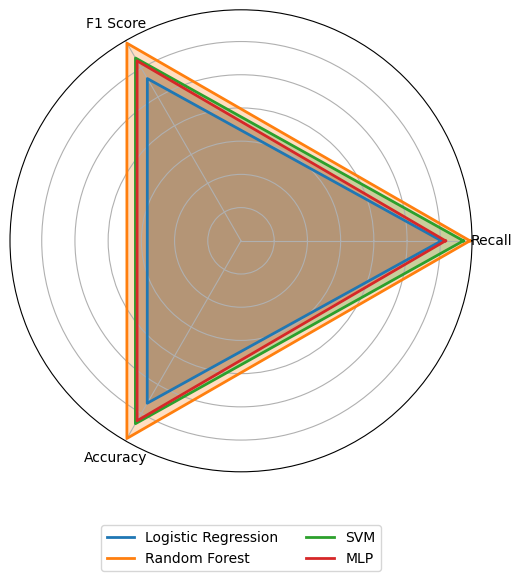

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Data
labels = ['Recall', 'F1 Score', 'Accuracy']
datasets = {
    'Logistic Regression': [df_results.loc[0, "Recall class 1"], df_results.loc[0, "F1-score"],	df_results.loc[0, "Accuracy"]],
    'Random Forest': [df_results.loc[1, "Recall class 1"], df_results.loc[1, "F1-score"],	df_results.loc[1, "Accuracy"]],
    'SVM': [df_results.loc[2, "Recall class 1"], df_results.loc[2, "F1-score"],	df_results.loc[2, "Accuracy"]],
    'MLP': [df_results.loc[3, "Recall class 1"], df_results.loc[3, "F1-score"],	df_results.loc[3, "Accuracy"]]
}

# Number of variables (features)
num_vars = len(labels)

# Calculate angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Complete the loop by repeating the first point to close the polygon
angles += angles[:1]

# Create a radar chart
fig, ax = plt.subplots(figsize=(6, 6), dpi=100, subplot_kw=dict(polar=True))

# Colors for each dataset
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot each dataset
for idx, (dataset, values) in enumerate(datasets.items()):
    values += values[:1]  # Ensure the loop closes
    ax.fill(angles, values, color=colors[idx], alpha=0.25)  # Fill the area
    ax.plot(angles, values, color=colors[idx], linewidth=2, label=dataset)  # Plot the line

# Add labels
ax.set_yticklabels([])  # Hide radial ticks
ax.set_xticks(angles[:-1])  # Place labels at each axis
ax.set_xticklabels(labels)

# Add legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# Show plot
plt.show()

## Random search on best model

After looking at the df of above, it can be seen that the best model is the Random Forest model. I therefore will perform random search on this model

In [45]:
# Further splitting trainval into train and validation set to tune hyperparameters on the validation set
# Training set: 70%, Validation set: 15%, Test set: 15% (still the same test set)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=(15/85), random_state=42)

In [46]:
print(X_train.shape)
print(f"The percentage of the original dataset that is used for training is: {X_train.shape[0]/df50.shape[0]*100} %")

(350000, 42)
The percentage of the original dataset that is used for training is: 70.0 %


In [47]:
from scipy.stats import randint  # For defining distributions for random search

param_dist = {
    'n_estimators': randint(50, 300),                       # Number of trees in the forest (uniform distribution between 50 and 200)
    'max_depth': [None] + list(randint(1, 30).rvs(10)),     # Random depth values including None
    'min_samples_split': randint(2, 10),                    # Minimum samples required to split an internal node
    'min_samples_leaf': randint(1, 5)                       # Minimum samples required to be at a leaf node
}

In [48]:
# Initialize the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_model_search = RandomForestClassifier(random_state=42)  # Random state for reproducibility


In [49]:
# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model_search,
                           param_distributions=param_dist,
                           n_iter=20,               # Number of parameter settings that are sampled
                           scoring='accuracy',      # Use recall as the evaluation metric
                           cv=k,
                           verbose=2,
                           n_jobs=-1)               # Use all available cores

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 93}
Best Cross-Validation Score: 0.6718457142857142


In [50]:
import json
import numpy as np

# Convert numpy.int64 to int (or other numpy types to native types)
best_params = {key: int(value) if isinstance(value, np.integer) else value
               for key, value in random_search.best_params_.items()}

# save parameters to json file

with open('best_params_del50.json', 'w') as file:
    json.dump(best_params, file)

In [51]:
y_pred_rf_random = random_search.predict(X_val)

print("Accuracy on Validation Set:", accuracy_score(y_val, y_pred_rf_random))
print(confusion_matrix(y_val, y_pred_rf_random))
print(classification_report(y_val, y_pred_rf_random))

from sklearn.metrics import recall_score
print("Recall on Validation Set:", recall_score(y_val, y_pred_rf_random))

Accuracy on Validation Set: 0.6741466666666667
[[25911 11718]
 [12721 24650]]
              precision    recall  f1-score   support

         0.0       0.67      0.69      0.68     37629
         1.0       0.68      0.66      0.67     37371

    accuracy                           0.67     75000
   macro avg       0.67      0.67      0.67     75000
weighted avg       0.67      0.67      0.67     75000

Recall on Validation Set: 0.6596023654705521


# Best found model on the test set

In [14]:
from sklearn.ensemble import RandomForestClassifier
import json

In [ ]:
# Load best found parameters from a JSON file
with open("best_params_del50.json", "r") as file:
    best_params_del50 = json.load(file)

In [ ]:
# Retrain the model with the best parameters on the entire train-validation set
final_model = RandomForestClassifier(**best_params_del50, random_state=42)

final_model.fit(X_trainval, y_trainval)

# Make predictions on the test set
y_pred_test = final_model.predict(X_test)

In [17]:
# predicting on the training set to be able to compare whether there is overfitting
y_pred_train = final_model.predict(X_trainval)

In [18]:
# Calculate accuracy train set
accuracy_train = accuracy_score(y_trainval, y_pred_train)
print(f"Accuracy train: {accuracy_train:.4f}")

# Calculate accuracy test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy test: {accuracy_test:.4f}")

Accuracy train: 0.7487
Accuracy test: 0.6846


In [19]:
# Calculate recall for class 1 on train set
recall_class_1_train = recall_score(y_trainval, y_pred_train, pos_label=1)
print(f"Recall for Class 1 test: {recall_class_1_train:.4f}")

# Calculate recall for class 1 on test set
recall_class_1_test = recall_score(y_test, y_pred_test, pos_label=1)
print(f"Recall for Class 1 test: {recall_class_1_test:.4f}")

Recall for Class 1 test: 0.7390
Recall for Class 1 test: 0.6721


In [20]:
from sklearn.metrics import f1_score

# Calculate F1-score for the train set
f1_train = f1_score(y_trainval, y_pred_train, average='macro')
print(f"F1-score train: {f1_train:.4f}")

# Calculate F1-score for the test set
f1_test = f1_score(y_test, y_pred_test, average='macro')
print(f"F1-score test: {f1_test:.4f}")

F1-score train: 0.7486
F1-score test: 0.6845


In [21]:
# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix


# Confusion Matrix train
conf_matrix_train = confusion_matrix(y_trainval, y_pred_train)
print("Confusion Matrix:\n", conf_matrix_train)

# Classification Report train
class_report_train = classification_report(y_trainval, y_pred_train)
print("Classification Report:\n", class_report_train)

print("\n")

# Confusion Matrix test
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:\n", conf_matrix_test)

# Classification Report test
class_report_test = classification_report(y_test, y_pred_test)
print("Classification Report:\n", class_report_test)

Confusion Matrix:
 [[161105  51345]
 [ 55476 157074]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.76      0.75    212450
           1       0.75      0.74      0.75    212550

    accuracy                           0.75    425000
   macro avg       0.75      0.75      0.75    425000
weighted avg       0.75      0.75      0.75    425000



Confusion Matrix:
 [[26173 11377]
 [12279 25171]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.70      0.69     37550
           1       0.69      0.67      0.68     37450

    accuracy                           0.68     75000
   macro avg       0.68      0.68      0.68     75000
weighted avg       0.68      0.68      0.68     75000



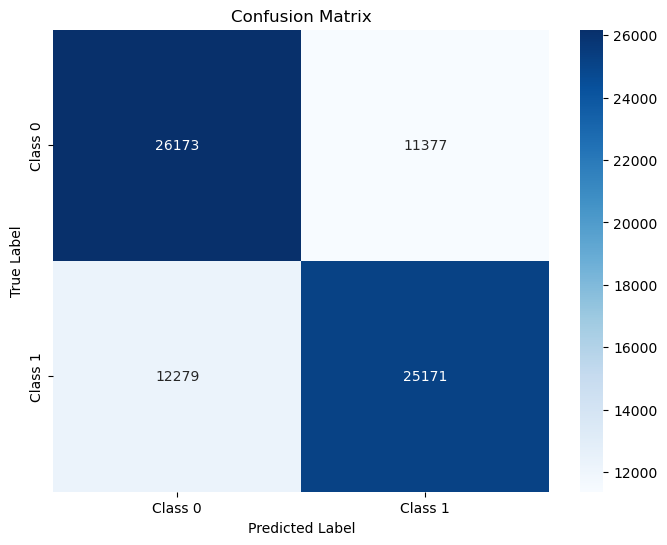

In [22]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [23]:
# saving so I can open in another notebook

import pickle

performance_metrics = {"Train": {"accuracy": accuracy_train, "conf_matrix": conf_matrix_train, "f1_score": f1_train, "recall": recall_class_1_train},
                       "Test": {"accuracy": accuracy_test, "conf_matrix": conf_matrix_test, "f1_score": f1_test, "recall": recall_class_1_test},
                       }

# Save to a pickle file
with open("performance_metrics_del50.pkl", "wb") as f:
    pickle.dump(performance_metrics, f)

In [24]:
# test with loading from a pickle file to see if it works
with open("performance_metrics_del50.pkl", "rb") as f:
    loaded_metrics = pickle.load(f)

print(loaded_metrics['Train']['accuracy'])

0.7486564705882353


### Permutation feature importance

In [25]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance
result = permutation_importance(final_model, X_test, y_test, n_repeats=10, random_state=42)

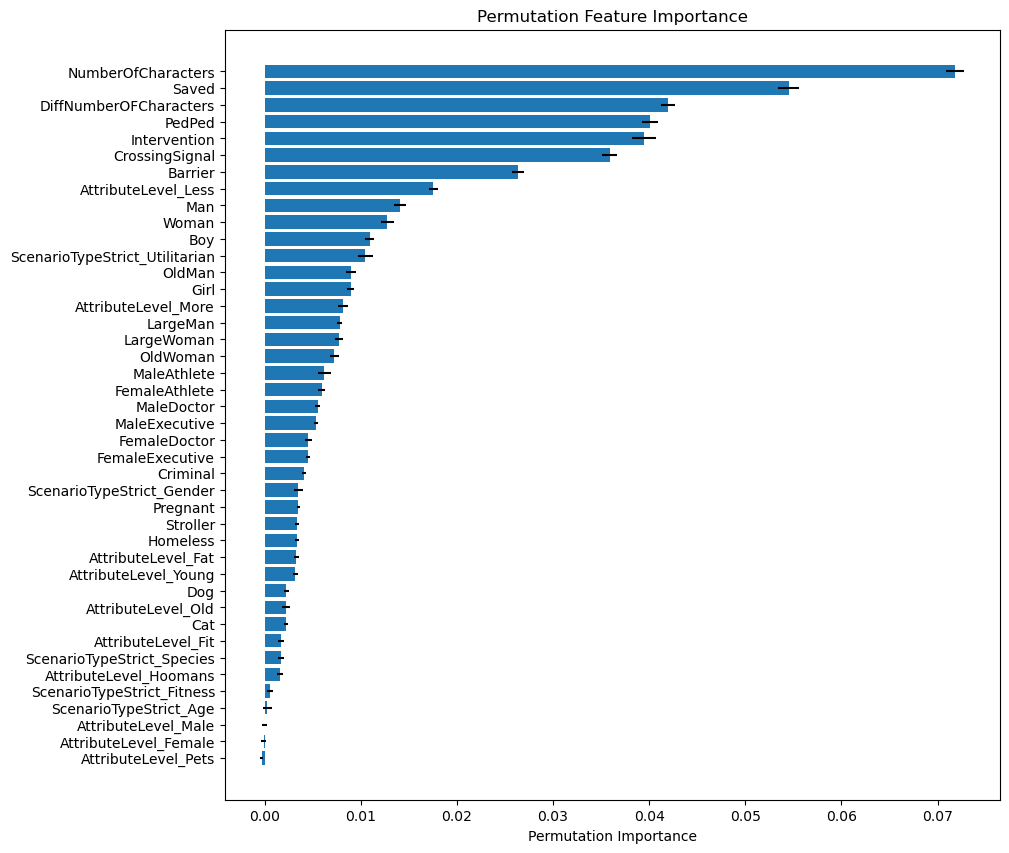

In [26]:
# Feature names
feature_names = X.columns

# Extract feature importances and standard deviations
importances = result.importances_mean
std = result.importances_std

# Sort the features by importance
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 10))
plt.barh(range(len(indices)), importances[indices], xerr=std[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Permutation Importance")
plt.title("Permutation Feature Importance")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()